# Notebook 2.6.3: The Freshman Plague

---

<br>

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey, (License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/))

Revised, Mike Augspurger (2021-present)

<br>

---

In [1]:
import pandas as pd
import numpy as np

def change_func(t, state, system):
    s, i, r = state.s, state.i, state.r

    infected = system['C'] * i * s
    recovered = system['R'] * i

    s -= infected
    i += infected - recovered
    r += recovered

    return pd.Series(dict(s=s, i=i, r=r),name="State")

def run_simulation(system, change_func):
    state = pd.Series(dict(s=system['iS'], i=system['iI'], r=system['iR']),
                      name="State Variables")
    frame = pd.DataFrame([],columns=state.index)
    frame.loc[0] = state

    for t in range(0, system['t_end']):
        frame.loc[t+1] = change_func(t, frame.loc[t], system)
    return frame

def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system['t_end']]
    return s_0 - s_end

def add_immunization(system, fraction):
    system['iS'] -= fraction
    system['iR'] += fraction

In [3]:
# Create a system
iS = 89; iI = 1; iR = 0
time_c = 3; time_r = 4; t_end = 14*7
N = iS + iI + iR

system = dict(iS=iS/N, iI=iI/N, iR=iR/N, N=N, C = 1/time_c,
              R = 1/time_r, t_end=t_end)

In [4]:
from numpy import exp

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.

    A: controls the lower bound
    B: controls the steepness of the transition
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition

    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

def linear(x,m,b):
    return m*x + b

def expon(x,a,b,c):
    return (a * exp(b*x)) - c

def step(x):
    x = x/2500
    return 0.5*x.round(1)

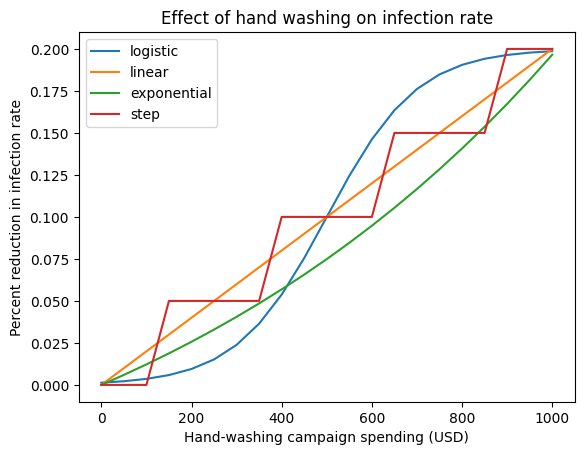

In [5]:
spending = np.linspace(0, 1000, 21)
log = logistic(spending, M=500, K=0.2, B=0.01)
lin = linear(spending,0.0002,0)
exp1 = expon(spending,0.12,0.00097,0.12)
step1 = step(spending)

#log,lin = compute_factor(spending) * 100

log = pd.Series(data=log,index=spending)
lin = pd.Series(data=lin,index=spending)
exp1 = pd.Series(data=exp1,index=spending)
step1 = pd.Series(data=step1,index=spending)

log.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         label='logistic',legend=True);
lin.plot(legend=True, label='linear')
exp1.plot(legend=True, label='exponential')
step1.plot(legend=True, label='step');

Now we need to use `compute_factor` to change the `C` for a particular simulation.

<br>

`add_hand_washing` takes a
systems object and a budget, and modifies `system['C']` to model the
effect of hand washing:

In [6]:
def add_hand_washing(system, spending):
    factor = logistic(spending, M=500, K=0.2, B=0.01)
    #factor = linear(spending,0.0002,0)
    system['C'] *= (1 - factor)

In [7]:
def sweep_hand_washing(system, spending_array):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS'], system['iI'],system['iR']
    C, R, t_end= system['C'], system['R'], system['t_end']

    for spending in spending_array:
        system_local = dict(iS=iS, iI=iI, iR=iR, N=N, C=C, R=R, t_end=t_end)
        add_hand_washing(system_local, spending)
        results = run_simulation(system_local, change_func)
        sweep[spending] = calc_total_infected(results, system_local)

    return sweep

In [8]:
from numpy import linspace

# Create the spending range through which we'll sweep
spending_array = linspace(0, 1200, 20)
# Calculate the percentage of total infected students for each spending value
infected_sweep2 = sweep_hand_washing(system,spending_array)

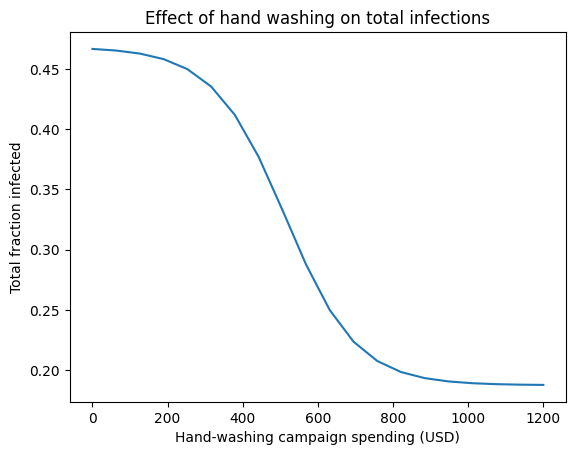

In [9]:
infected_sweep2.plot(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections');

## Optimization

Here's our budget

In [10]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)


In [13]:
def sweep_doses(system,dose_array):
    sweep = pd.Series([],dtype=object)

    # Unpack variables from original system and return to argument state
    N = system['N']
    iS, iI, iR = system['iS'], system['iI'],system['iR']
    C, R, t_end= system['C'], system['R'], system['t_end']

    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose

        # Adjust system according to preventive actions
        system_local = dict(iS=iS, iI=iI, iR=iR, N=N, C=C, R=R, t_end=t_end)
        add_immunization(system_local, fraction)
        add_hand_washing(system_local, spending)

        # Find results for each budget option
        results = run_simulation(system_local, change_func)
        sweep[doses] = calc_total_infected(results, system_local)

    return sweep

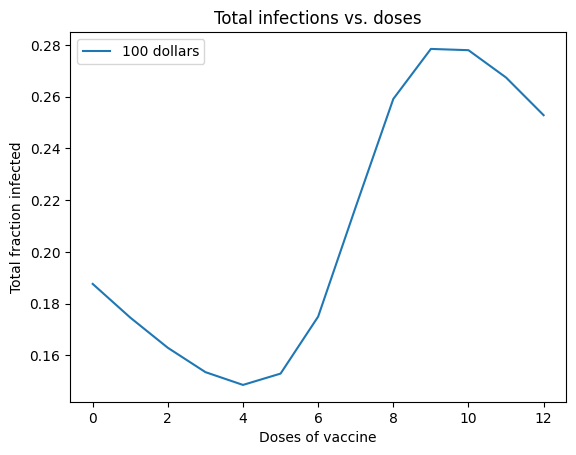

In [14]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)

infected_sweep3 = sweep_doses(system,dose_array)
infected_sweep3.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',label='100 dollars',
         legend=True);

### Exploring the system

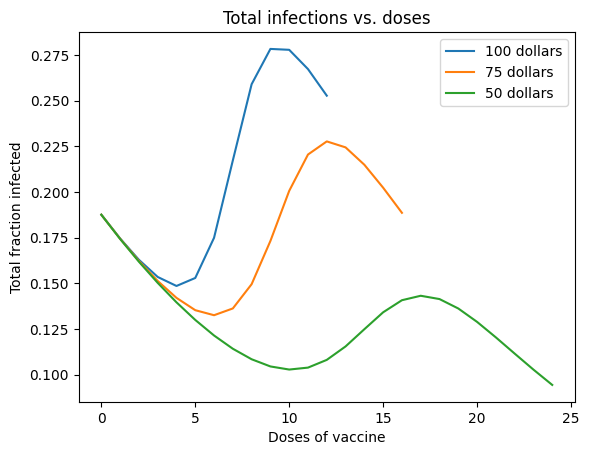

In [15]:
# Run and plot the results of sweep_doses here
num_students = 90
budget = 1200
price_per_dose = 75
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_75 = sweep_doses(system,dose_array)

price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_50 = sweep_doses(system,dose_array)

infected_sweep3.plot(label='100 dollars',legend=True)
infected_sweep_75.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=True,label='75 dollars');
infected_sweep_50.plot(label='50 dollars',legend=True);

In [ ]:
# Change the budget
num_students = 90
budget = 2000
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)

infected_sweep_2000 = sweep_doses(system,dose_array)

num_students = 90
budget = 600
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = np.arange(0,max_doses+1,1)
infected_sweep_600 = sweep_doses(system,dose_array)


infected_sweep_600.plot(label='600 dollars',legend=True)
infected_sweep3.plot(label='1200 dollars',legend=True)
infected_sweep_2000.plot(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=True,label='2000 dollars');